In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import measurements
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
import pickle

In [2]:
class Tracker():
    # class to create and store information of vehicle detections on an image or a series of images
    def __init__(self, classifier, feature_extractor, features_scaler, max_to_keep = 1, heat_threshold=0):
        self.clf = classifier
        self.feature_extractor = feature_extractor
        self.scaler = features_scaler
        self.heatmaps = None
        self.max_to_keep = max_to_keep
        self.heat_threshold = heat_threshold
        
    def set_track_params(self, scale_dict, init_size, step, video_mode=True):
        self.scale_dict = scale_dict
        self.init_size = init_size
        self.step = step
        self.video_mode = video_mode
        
    def track(self, img):
        heatmaps, _, _ = self.detect_multiscale(img, self.scale_dict, False,
                        init_size=self.init_size, step=self.step)
        multiscale_heatmap, _, draw_img = self.draw_multiscale(img, heatmaps)
        
        if self.video_mode:
            if self.heatmaps is None:
                self.heatmaps = multiscale_heatmap[np.newaxis]
            else:
                self.heatmaps = np.vstack([multiscale_heatmap[np.newaxis], self.heatmaps])
                if self.heatmaps.shape[0] > self.max_to_keep:
                    self.heatmaps = self.heatmaps[:self.max_to_keep, :, :]
                sum_heat = self.sum_with_threshold(self.heatmaps, self.heat_threshold)
                multiscale_heatmap, _, draw_img = self.draw_multiscale(img, sum_heat)
            
        return draw_img
                
    def sum_with_threshold(self, heatmaps, threshold):
        sum_heat = np.sum(heatmaps, axis=0)
        sum_heat[sum_heat<=threshold] = 0
        return sum_heat
        
        
    def draw_multiscale(self, img, heatmaps_, threshold=None):
        draw_img = img.copy()
        heatmaps = heatmaps_.copy()
        if threshold is not None:
            heatmaps[heatmaps<=threshold]=0
        ones_heatmap = np.zeros_like(heatmaps)
        ones_heatmap[heatmaps>0] = 1
        labeled_map, labels = measurements.label(ones_heatmap)
        multiscale_heatmap = np.zeros_like(heatmaps)
        multiscale_bboxes = []
        for label_ in range(labels):
            yc, xc, sw = 0, 0, 0
            x_s, y_s = [], []
            selection = labeled_map.copy()
            selection[selection != (label_+1)] = 0
            rows, cols = np.nonzero(selection)
            pts = np.array([rows,cols]).T
            for pt in pts:
                w = heatmaps[pt[0], pt[1]]
                yc += pt[0]*w
                xc += pt[1]*w
                x_s.append(pt[1])
                y_s.append(pt[0])
                sw += w
            yc /= sw
            xc /= sw
            xmin = min(x_s)
            xmax = max(x_s)
            ymin = min(y_s)
            ymax = max(y_s)
            w_2 = min(abs(xmin-xc), abs(xmax-xc))
            h_2 = min(abs(ymin-yc), abs(ymax-yc))
            x1 = int(max(0,xc-w_2))
            x2 = int(min(img.shape[1], xc+w_2))
            y1 = int(max(0, yc-h_2))
            y2 = int(min(img.shape[0], yc+h_2))
            label_bbox = (x1,y1,x2,y2)
            multiscale_heatmap[y1:y2, x1:x2] = 1
            cv2.rectangle(draw_img, (x1,y1), (x2,y2), (0,255,0), 6)
            multiscale_bboxes.append(label_bbox)
        return multiscale_heatmap, multiscale_bboxes, draw_img
        
    def detect_multiscale(self, img, scale_dict, return_images=False, step=0.125):
        heatmaps = None
        draw_imgs = None
        bboxes_scaled = []
        for k,v in scale_dict.items():
            scale = k
            ymin, ymax, xmin, xmax = v
            heat, bbox, draw = self.detect_cars(img, ymin, ymax, xmin, xmax,
                    init_size, scale, step)
            if heatmaps is None:
                heatmaps = heat*scale
            else:
                heatmaps += heat*scale
            if return_images:
                if draw_imgs is None:
                    draw_imgs = draw[np.newaxis]
                else:
                    draw_imgs = np.vstack([draw_imgs, draw[np.newaxis]])
            bboxes_scaled.append((scale,bbox))
        return heatmaps, bboxes_scaled, draw_imgs


    def detect_cars(self, img, ymin, ymax, xmin, xmax, init_size, scale, step):
        features = self.feature_extractor.return_sliding_features(img, ymin, ymax, xmin, xmax,
                                init_size, scale, step)
        scaled_features = self.scaler.transform(features)
        predictions = self.clf.predict(scaled_features)
        heatmap, bboxes, draw_img = self.draw_detections(img, ymin, ymax, xmin, xmax, predictions, init_size, scale, step)
        return heatmap, bboxes, draw_img

    def draw_detections(self, img, ymin, ymax, xmin, xmax, predictions, init_size, scale, step):
        draw_img = img.copy()
        heatmap = np.zeros((img.shape[0], img.shape[1]))
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        pred = predictions.reshape(nsteps_y, nsteps_x)
        ywin = y_init*scale
        xwin = x_init*scale
        bboxes = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                car = pred[i,j]
                if car == 1:
                    x_start = int(xmin+j*x_init*scale*step)
                    x_end = int(x_start + xwin)
                    y_start = int(ymin + i*y_init*scale*step)
                    y_end =int(y_start+ywin)
                    cv2.rectangle(draw_img, (x_start, y_start), (x_end, y_end), (0,255,0), 6)
                    heatmap[y_start:y_end, x_start:x_end] = 1
                    bboxes.append((x_start, y_start, x_end, y_end))
        return heatmap, bboxes, draw_img

    
    

In [28]:
from skimage.feature import hog

class FeatureExtractor():
    # class for feature extraction from an image for classification
    def __init__(self, feature_types=['HOG'],
               sum_hog=False, hog_norm_by_channel=False,
               hog_color_transform=None, hog_channels=[0],
               hog_pix_per_cell=8, hog_cell_per_block=2, hog_orient=9,
               hog_vis=False,
               color_transform_flag=None, spat_size=(32,32),
               hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
        self.feature_types = feature_types
        self.sum_hog = sum_hog
        self.hog_norm_by_channel = hog_norm_by_channel
        self.hog_color_transform = hog_color_transform
        self.hog_channels = hog_channels
        self.hog_pix_per_cell = hog_pix_per_cell
        self.hog_cell_per_block = hog_cell_per_block
        self.hog_orient = hog_orient
        self.hog_vis = hog_vis
        self.color_transform = color_transform_flag
        self.spat_size = spat_size
        self.hist_channels = hist_channels
        self.hist_nbins = hist_nbins
        self.hist_bins_range = hist_bins_range
        
        
    def return_features_and_labels(self, class_files, class_label):
        class_features = None
        class_labels = class_label*np.ones(len(class_files))
        for imfile in class_files:
            img = cv2.imread(imfile)
            features = np.array([], dtype=np.float64)
            for feature_type in self.feature_types:
                features_ = self.return_features(img, feature_type, flatten_hog=True)[0] # the first element is feature vector anyway
                features=np.concatenate((features, features_))
            if class_features is None:
                class_features = features[np.newaxis]
            else:
                class_features = np.vstack([class_features, features[np.newaxis]])
        return class_features, class_labels
    
    def return_features(self, img, feature_type, flatten_hog=False):
        if feature_type == 'HOG':
            return self.return_hog(img, flatten_hog)
        elif feature_type == 'HOGMULTI':
            return self.return_hog_multichannel(img, flatten_hog)
        elif feature_type == 'SPAT':
            return self.return_spat(img)
        elif feature_type == 'HIST':
            return self.return_hist(img)
        else:
            raise ValueError
            
    def return_hog_multichannel(self, img__, flatten_hog):
        if self.hog_color_transform is None:
            img = img__.copy()
        else:
            img = cv2.cvtColor(img__, self.hog_color_transform)
        
        if img.ndim == 2:
            img = img[:,:,np.newaxis]
        hog_joint = None
        
        for channel in self.hog_channels:
            img_channel = img[:,:,channel]
            return_list = hog(img_channel, orientations=self.hog_orient, pixels_per_cell=(self.hog_pix_per_cell, self.hog_pix_per_cell),
                              cells_per_block=(self.hog_cell_per_block, self.hog_cell_per_block),
                              block_norm= 'L2-Hys', transform_sqrt=False, 
                              visualise= self.hog_vis, feature_vector=flatten_hog)
    
            hog_features = return_list
            if hog_joint is None:
                hog_joint = hog_features[np.newaxis]
            else:
                hog_joint = np.vstack([hog_joint, hog_features[np.newaxis]])

        if sum_hog:
            hog_joint = np.sum(hog_joint, axis=0)
        
        if flatten_hog:
            hog_joint = hog_joint.ravel()
        return [hog_joint]
            
    def return_hog(self, img__, flatten_hog):
        if color_transform is None:
            img = img__.copy()
        else:
            img = cv2.cvtColor(img__, self.hog_color_transform)
        
        if vis:
            varray = None

        return_list = hog(img, orientations=self.hog_orient, pixels_per_cell=(self.hog_pix_per_cell, self.hog_pix_per_cell),
                              cells_per_block=(self.hog_cell_per_block, self.hog_cell_per_block),
                              block_norm= 'L2-Hys', transform_sqrt=False, 
                              visualise= self.hog_vis, feature_vector= self.hog_feature_vec)
        if not self.hog_vis:
            hog_features = return_list
        else:
            hog_features = return_list[0]
        hog_joint = hog_features
        if self.hog_vis:
            if varray is None:
                varray = return_list[1][np.newaxis]
            else:
                varray = np.vstack(varray, return_list[1][np.newaxis])
        if self.hog_vis:
            return hog_joint, varray
        else:
            return [hog_joint]
        
    def return_spat(self, img):
        if self.color_transform is None:
            feature_image = img.copy()
        else:
            feature_image = cv2.cvtColor(img, self.color_transform)           
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(feature_image, self.spat_size).ravel().astype(np.float64)
        # Return the feature vector
        return [features]
    
    def return_hist(self, img):
        if self.color_transform is None:
            feature_image = img.copy()
        else:
            feature_image = cv2.cvtColor(img, self.color_transform)  
        # take an arbitrary channel for getting bin centers
        rhist = np.histogram(feature_image[:,:,0], bins=self.hist_nbins, range=self.hist_bins_range)
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        # Concatenate the histograms into a single feature vector
        hist_features = []
        for channel in self.hist_channels:
            hist, _ = np.histogram(feature_image[:,:,channel], bins=self.hist_nbins, range=self.hist_bins_range, density=True)
            hist_features.append(hist)
        hist_features_joint = np.array(hist_features, dtype=np.float64).flatten()
        # Return the individual histograms, bin_centers and feature vector
        return hist_features_joint, hist_features, bin_centers

    def return_sliding_features(self, img, ymin, ymax, xmin, xmax,
                            init_size=(64,64), scale=1, step=0.125):
        features = None
        for ftype in self.feature_types:
            if ftype == 'HOG':
                ft = self.return_sliding_hog(img, ymin, ymax, xmin, xmax,
                                       init_size=init_size, scale=scale, step=step)
            elif ftype == 'HOGMULTI':
                ft = self.return_sliding_hog_multi(img, ymin, ymax, xmin, xmax,
                                                   init_size=init_size, scale=scale, step=step)
            elif ftype == 'SPAT':
                ft = self.return_sliding_spat(img, ymin, ymax, xmin, xmax, 
                                         init_size=init_size, scale=scale, step=step)
            elif ftype == 'HIST':
                ft = self.return_sliding_hist(img, ymin, ymax, xmin, xmax, 
                                         init_size=init_size, scale=scale, step=step)
            else:
                raise ValueError
            if features is None:
                features = ft
            else:
                features = np.hstack([features, ft])
        return features

    def return_sliding_hog_multi(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1, step=0.125):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        delta_index_y = math.floor(step*y_init/cell_size)
        delta_index_x = math.floor(step*x_init/cell_size)
        dy_hog = y_init//cell_size - 1
        dx_hog = x_init//cell_size - 1
        resized_hog = self.return_features(resized_img, 'HOGMULTI', flatten_hog=False)[0]
        window_features = []
        for i in range(nsteps_y):
            y_ind = i*delta_index_y
            for j in range(nsteps_x):
                x_ind = j*delta_index_x
                for channel in self.hog_channels:
                    window_hog = resized_hog[channel, y_ind:(y_ind+dy_hog),x_ind:(x_ind+dx_hog),:]
                    window_features.append(window_hog.ravel())
        return np.array(window_features)
    
    def return_sliding_hog(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1, step=0.125):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        delta_index_y = math.floor(step*y_init/cell_size)
        delta_index_x = math.floor(step*x_init/cell_size)
        dy_hog = y_init//cell_size - 1
        dx_hog = x_init//cell_size - 1
        resized_hog = self.return_features(resized_img, 'HOG', flatten_hog=False)[0]
        window_features = []
        for i in range(nsteps_y):
            y_ind = i*delta_index_y
            for j in range(nsteps_x):
                x_ind = j*delta_index_x
                window_hog = resized_hog[y_ind:(y_ind+dy_hog),x_ind:(x_ind+dx_hog),:]
                window_features.append(window_hog.ravel())

        return np.array(window_features) #, np.array(window_imgs)

    def return_sliding_spat(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1,
                            step=0.125):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        window_features = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
                features = self.return_features(window_img, 'SPAT')[0]
                window_features.append(features)
        return np.array(window_features)

    def return_sliding_hist(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1,
                            step=0.125):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        window_features = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
                features = self.return_features(window_img, 'HIST')[0]
                window_features.append(features)
        return np.array(window_features)
    

# Train classifier

## Data observation

In [14]:
VEHICLES_PATH = './vehicles/vehicles/'
NONVEHICLES_PATH = './non-vehicles/non-vehicles/'

In [15]:
vehicle_files = [os.path.join(VEHICLES_PATH, x, y) for\
                 x in os.listdir(VEHICLES_PATH) for y in os.listdir(os.path.join(VEHICLES_PATH,x)) if y!='.DS_Store']

In [16]:
nonvehicle_files = [os.path.join(NONVEHICLES_PATH, x, y) for\
                 x in os.listdir(NONVEHICLES_PATH) if x!='.DS_Store' for y in os.listdir(os.path.join(NONVEHICLES_PATH,x)) if y!='.DS_Store']

In [17]:
len(vehicle_files), len(nonvehicle_files)

(8792, 8968)

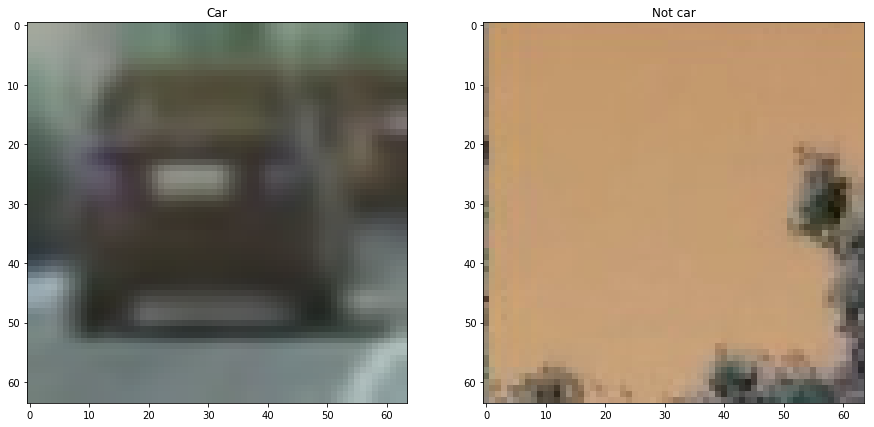

In [18]:
%matplotlib inline
vehicle = cv2.imread(vehicle_files[0])
nonvehicle = cv2.imread(nonvehicle_files[0])
fig = plt.figure(figsize=(15,10))
a = fig.add_subplot(1,2,1, title='Car')
plt.imshow(vehicle)
a = fig.add_subplot(1,2,2, title='Not car')
plt.imshow(nonvehicle)

In [33]:
# define parameters for feature extractor:
feature_types=['HOGMULTI', 'HIST']
sum_hog=True
hog_norm_by_channel=False
hog_color_transform=cv2.COLOR_BGR2RGB
hog_channels=[0,1,2]
hog_pix_per_cell=8
hog_cell_per_block=2
hog_orient=9
hog_vis=False
color_transform_flag=cv2.COLOR_BGR2RGB
spat_size=(32,32),
hist_channels=[0,1,2]
hist_nbins=32
hist_bins_range=(0,256)

In [34]:
feature_extractor = FeatureExtractor(feature_types, sum_hog, hog_norm_by_channel,
                                    hog_color_transform, hog_channels,
                                    hog_pix_per_cell, hog_cell_per_block,
                                    hog_orient,
                                    hog_vis,
                                    color_transform_flag,
                                    spat_size,
                                    hist_channels,
                                    hist_nbins,
                                    hist_bins_range)

In [35]:
vehicle_features, vehicle_labels = feature_extractor.return_features_and_labels(vehicle_files, 1)

In [36]:
nonvehicle_features, nonvehicle_labels = feature_extractor.return_features_and_labels(nonvehicle_files, 0)

In [37]:
vehicle_features.shape, nonvehicle_features.shape

((8792, 1860), (8968, 1860))

In [38]:
import pickle
vehicles = dict()
nonvehicles = dict()
vehicles['features'] = vehicle_features
vehicles['labels'] = vehicle_labels
nonvehicles['features'] = nonvehicle_features
nonvehicles['labels'] = nonvehicle_labels
with open('./data/vehicles_hog_hist.p', 'wb') as f:
    pickle.dump(vehicles, f)
with open('./data/nonvehicles_hog_hist.p', 'wb') as f:
    pickle.dump(nonvehicles, f)

## Train classifier

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
vehicles_train_features, vehicles_test_features, vehicles_train_labels,  vehicle_test_labels = train_test_split(
    vehicle_features, vehicle_labels, test_size=0.2, random_state=123)

In [41]:
nonvehicles_train_features, nonvehicles_test_features, nonvehicles_train_labels, nonvehicles_test_labels = train_test_split(
    nonvehicle_features, nonvehicle_labels, test_size=0.2, random_state=123)

In [42]:
train_features = np.vstack([vehicles_train_features, nonvehicles_train_features])
train_labels = np.concatenate((vehicles_train_labels, nonvehicles_train_labels))
test_features = np.vstack([vehicles_test_features, nonvehicles_test_features])
test_labels = np.concatenate((vehicle_test_labels, nonvehicles_test_labels))

In [43]:
train_features.shape, test_features.shape

((14207, 1860), (3553, 1860))

In [44]:
train_labels.shape, test_labels.shape

((14207,), (3553,))

In [45]:
from sklearn.utils import shuffle

In [46]:
train_features, train_labels = shuffle(train_features, train_labels)

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
scaler = StandardScaler()
scaler.fit(train_features)
train_features_scaled = scaler.transform(train_features)

In [49]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, make_scorer

In [50]:
from sklearn.svm import SVC

In [51]:
SVC?

In [ ]:
kf = KFold(n_splits=3)
estimator = SVC()
param_grid = {'kernel':['linear', 'rbf'], 'C': [0.1, 1], 'gamma':['auto', 0.001]}
scorer = make_scorer(accuracy_score)
clf = GridSearchCV(estimator, param_grid=param_grid, cv=kf, scoring=scorer, verbose=3)
clf.fit(train_features_scaled, train_labels)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=0.1, gamma=auto, kernel=linear ................................
[CV] . C=0.1, gamma=auto, kernel=linear, score=0.974029, total=  30.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.0s remaining:    0.0s


[CV] C=0.1, gamma=auto, kernel=linear ................................
[CV] . C=0.1, gamma=auto, kernel=linear, score=0.973395, total=  33.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] C=0.1, gamma=auto, kernel=linear ................................
[CV] . C=0.1, gamma=auto, kernel=linear, score=0.977191, total=  32.3s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] .... C=0.1, gamma=auto, kernel=rbf, score=0.939400, total= 1.9min
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] .... C=0.1, gamma=auto, kernel=rbf, score=0.941723, total= 1.9min
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] .... C=0.1, gamma=auto, kernel=rbf, score=0.946146, total= 1.9min
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV]  C=0.1, gamma=0.001, kernel=linear, score=0.974029, total=  30.8s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV]  C=0.1, gamma=0.001, kernel=linear, score=0.973395, total=  33.2s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV]  C=0.1, gamma=0.001, kernel=linear, score=0.977191, total=  32.1s
[CV] C

In [217]:
classifier = clf.best_estimator_

In [218]:
classifier

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [219]:
with open('./data/clf_hog_hist.p', 'wb') as f:
    pickle.dump(classifier, f)

In [220]:
# estimate accuracy
test_features_scaled = scaler.transform(test_features)

In [221]:
with open('./data/scl_hog_hist.p', 'wb') as f:
    pickle.dump(scaler, f)

In [222]:
predictions = classifier.predict(test_features_scaled)

In [223]:
accuracy_score(test_labels, predictions)

0.98001688713763013

## Test tracker

In [68]:
test_path = './cut_test_video/'
test_files = [os.path.join(test_path, x) for x in os.listdir(test_path) if x.endswith('.jpg')]
with open('./data/scl_hog_hist.p', 'rb') as f:
    im_scaler = pickle.load(f)
with open('./data/clf_hog_hist.p', 'rb') as f:
    classifier = pickle.load(f)
scale_dict = { 1:(390,600,0,1280)}
hist_ch = [0,1,2]
ftypes = ['HOGMULTI','HIST']
init_size = (64,64)
step=0.25
feature_extractor = FeatureExtractor()
tracker = Tracker(classifier, feature_extractor, im_scaler, max_to_keep = 1, heat_threshold=0)

In [69]:
tracker.set_track_params(step=step, scale_dict=scale_dict, feature_types=ftypes, hist_channels=hist_ch, init_size=init_size)

In [70]:
hog_color_transform=hog_color_transform, color_transform_flag=hog_color_transform, 
    feature_types=['HOGMULTI', 'HIST'], hog_channels=[0,1,2],
    hist_channels=[0,1,2], sum_hog=True

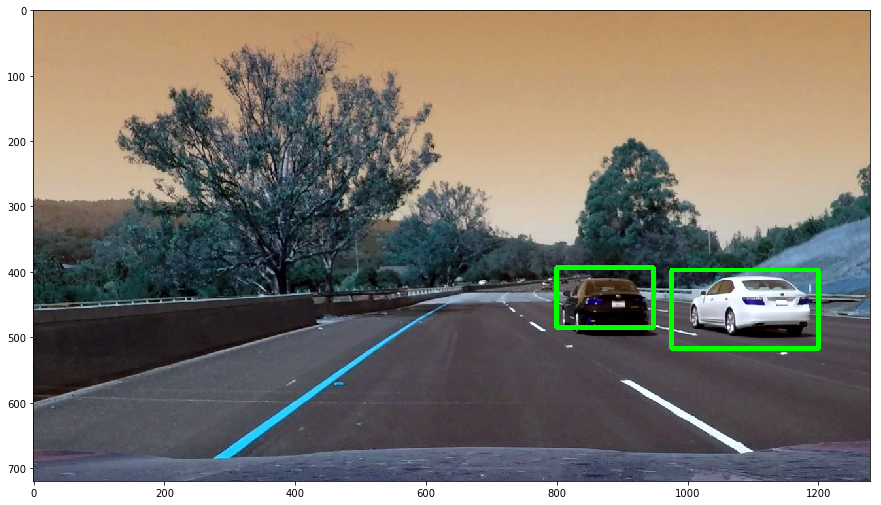

In [71]:
t1 = time.time()
fig = plt.figure(figsize=(15,10))
for i, file in enumerate(test_files):
    test_img = cv2.imread(file)
    im_w_detections = tracker.track(test_img, video_mode=False)
    plt.imshow(im_w_detections)
    break
plt.show()
t2 = time.time()

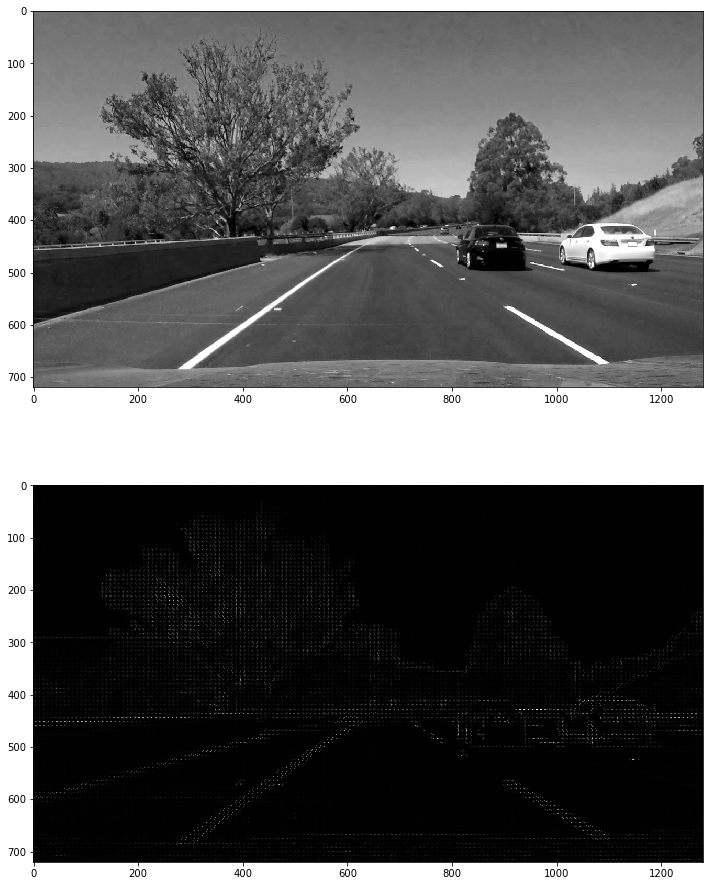

In [150]:
test_path = './cut_test_video/'
test_files = [os.path.join(test_path, x) for x in os.listdir(test_path) if x.endswith('.jpg')]
tfile = cv2.imread(test_files[0])
conv_file = cv2.cvtColor(tfile, cv2.COLOR_BGR2RGB)
sum_ft = np.zeros((conv_file.shape[0], conv_file.shape[1]))
for channel in range(1):
    _, features_img = feature_extractor.return_hog(conv_file[:,:,channel], vis=True)
    features_img = features_img[0]
    #features_img /= np.max(features_img)
    sum_ft += features_img
#features_img = features_img[0]
fig = plt.figure(figsize=(12,16))
fig.add_subplot(2,1,1)
plt.imshow(conv_file[:,:,channel], cmap='gray')
fig.add_subplot(2,1,2)
plt.imshow(sum_ft, cmap='gray')
plt.show()
hist, _, _ = feature_extractor.return_hist(conv_file, color_transform=None, channels=[0], nbins=32, bins_range=(0, 256))

In [152]:
np.max(sum_ft)

46.028238654136658

In [133]:
np.histogram?

## Make video

In [ ]:
with open('./data/scl.p', 'rb') as f:
    im_scaler = pickle.load(f)
with open('./data/clf.p', 'rb') as f:
    classifier = pickle.load(f)
scale_dict = {1:(360,550,0,1280)}
hist_ch = [0,1,2]
ftypes = ['HOG', 'SPAT','HIST']
init_size = (64,64)
step=0.25
feature_extractor = FeatureExtractor()
output = './output_videos/project_out_1.mp4'
color_trans = cv2.COLOR_RGB2BGR
tracker = Tracker(classifier, feature_extractor, im_scaler, max_to_keep = 5, heat_threshold=3)
tracker.set_track_params(step=step, scale_dict=scale_dict, feature_types=ftypes, hist_channels=hist_ch,
                         init_size=init_size, color_transform=color_trans)
img_processor = tracker.track
clip1 = VideoFileClip("./test_video.mp4")
clip = clip1.fl_image(img_processor)
%time clip.write_videofile(output, audio=False)

In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [47]:
cam = cv2.VideoCapture('./test_video.mp4')
ret = True
cntr = 0
while ret:
    ret, frame = cam.read()
    cv2.imwrite(os.path.join('./cut_test_video/', 'frame_' + str(cntr)+'.jpg'), frame)
    cntr += 1

In [573]:
print(t2-t1)

53.8247389793396


In [366]:
import math

def return_sliding_features(img, ymin, ymax, xmin, xmax, feature_extractor, feature_types=['HOG', 'SPAT', 'HIST'],
                            init_size=(64,64), scale=1, step=0.125,
                           cell_size=8, hog_color_transform=cv2.COLOR_BGR2GRAY,
                           color_transform=None, spat_size=(32,32),
                           hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
    features = None
    for ftype in feature_types:
        if ftype == 'HOG':
            ft = return_sliding_hog(img, ymin, ymax, xmin, xmax, feature_extractor,
                                   init_size=init_size, scale=scale, step=step,
                                   cell_size=cell_size, hog_color_transform=hog_color_transform)
        elif ftype == 'SPAT':
            ft = return_sliding_spat(img, ymin, ymax, xmin, xmax, feature_extractor,
                                     init_size=init_size, scale=scale,
                                     step=step, color_transform=color_transform, spat_size=spat_size)
        elif ftype == 'HIST':
            ft = return_sliding_hist(img, ymin, ymax, xmin, xmax, feature_extractor,
                                     init_size=init_size, scale=scale, step=step,
                                     color_transform=color_transform, hist_channels=hist_channels,
                                     hist_nbins=hist_nbins, hist_bins_range=hist_bins_range)
        else:
            raise ValueError
        if features is None:
            features = ft
        else:
            features = np.hstack([features, ft])
    return features
    
def return_sliding_hog(img, ymin, ymax, xmin, xmax, feature_extractor, init_size=(64,64), scale=1, step=0.125, cell_size=8,
                         hog_color_transform=cv2.COLOR_BGR2GRAY):
    roi = img[ymin:ymax, xmin:xmax, :]
    dy = ymax-ymin
    dx = xmax-xmin
    dy_sc = int(dy/scale)
    dx_sc = int(dx/scale)
    x_init, y_init = init_size
    resized_img = cv2.resize(roi, (dx_sc,dy_sc))
    nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
    nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
    delta_index_y = math.floor(step*y_init/cell_size)
    delta_index_x = math.floor(step*x_init/cell_size)
    dy_hog = y_init//cell_size - 1
    dx_hog = x_init//cell_size - 1
    resized_hog = feature_extractor.return_features(resized_img, 'HOG',
                                                    hog_color_transform=cv2.COLOR_BGR2GRAY, hog_feature_vec=False)[0]
    window_features = []
    for i in range(nsteps_y):
        y_ind = i*delta_index_y
        for j in range(nsteps_x):
            x_ind = j*delta_index_x
            window_hog = resized_hog[y_ind:(y_ind+dy_hog),x_ind:(x_ind+dx_hog),:]
            window_features.append(window_hog.ravel())
            
    return np.array(window_features) #, np.array(window_imgs)

def return_sliding_spat(img, ymin, ymax, xmin, xmax, feature_extractor, init_size=(64,64), scale=1,
                        step=0.125, color_transform=None, spat_size=(32,32)):
    roi = img[ymin:ymax, xmin:xmax, :]
    dy = ymax-ymin
    dx = xmax-xmin
    dy_sc = int(dy/scale)
    dx_sc = int(dx/scale)
    x_init, y_init = init_size
    resized_img = cv2.resize(roi, (dx_sc,dy_sc))
    nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
    nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
    window_features = []
    for i in range(nsteps_y):
        for j in range(nsteps_x):
            window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
            features = feature_extractor.return_features(window_img, 'SPAT',
                                                        color_transform_flag=color_transform, spat_size=spat_size)[0]
            window_features.append(features)
    return np.array(window_features)

def return_sliding_hist(img, ymin, ymax, xmin, xmax, feature_extractor, init_size=(64,64), scale=1,
                        step=0.125, color_transform=None,hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
    roi = img[ymin:ymax, xmin:xmax, :]
    dy = ymax-ymin
    dx = xmax-xmin
    dy_sc = int(dy/scale)
    dx_sc = int(dx/scale)
    x_init, y_init = init_size
    resized_img = cv2.resize(roi, (dx_sc,dy_sc))
    nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
    nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
    window_features = []
    for i in range(nsteps_y):
        for j in range(nsteps_x):
            window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
            features = feature_extractor.return_features(window_img, 'HIST',
                                                        color_transform_flag=color_transform,
                                                        hist_channels=hist_channels, hist_nbins=hist_nbins,
                                                        hist_bins_range=hist_bins_range)[0]
            window_features.append(features)
    return np.array(window_features)

In [531]:
def draw_multiscale(img, heatmaps_, bboxes_scaled, threshold=None):
    draw_img = img.copy()
    heatmaps = heatmaps_.copy()
    if threshold is not None:
        heatmaps[heatmaps<=threshold]=0
    ones_heatmap = np.zeros_like(heatmaps)
    ones_heatmap[heatmaps>0] = 1
    labeled_map, labels = measurements.label(ones_heatmap)
    multiscale_heatmap = np.zeros_like(heatmaps)
    multiscale_bboxes = []
    for label_ in range(labels):
        yc, xc, sw = 0, 0, 0
        x_s, y_s = [], []
        selection = labeled_map.copy()
        selection[selection != (label_+1)] = 0
        rows, cols = np.nonzero(selection)
        pts = np.array([rows,cols]).T
        for pt in pts:
            w = heatmaps[pt[0], pt[1]]
            yc += pt[0]*w
            xc += pt[1]*w
            x_s.append(pt[1])
            y_s.append(pt[0])
            sw += w
        yc /= sw
        xc /= sw
        xmin = min(x_s)
        xmax = max(x_s)
        ymin = min(y_s)
        ymax = max(y_s)
        w_2 = min(abs(xmin-xc), abs(xmax-xc))
        h_2 = min(abs(ymin-yc), abs(ymax-yc))
        x1 = int(max(0,xc-w_2))
        x2 = int(min(img.shape[1], xc+w_2))
        y1 = int(max(0, yc-h_2))
        y2 = int(min(img.shape[0], yc+h_2))
        label_bbox = (x1,y1,x2,y2)
        print(label_bbox)
        multiscale_heatmap[y1:y2, x1:x2] = 1
        cv2.rectangle(draw_img, (x1,y1), (x2,y2), (0,255,0), 6)
        multiscale_bboxes.append(label_bbox)
    return multiscale_heatmap, multiscale_bboxes, draw_img
            
def detect_multiscale(img, scale_dict, feature_extractor, classifier, scaler, threshold=None, return_images=False,
                     feature_types=['HOG', 'SPAT', 'HIST'],
                        init_size=(64,64), step=0.125,
                        cell_size=8, hog_color_transform=cv2.COLOR_BGR2GRAY,
                        color_transform=None, spat_size=(32,32),
                        hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
    heatmaps = None
    draw_imgs = None
    bboxes_scaled = []
    for k,v in scale_dict.items():
        scale = k
        ymin, ymax, xmin, xmax = v
        heat, bbox, draw = detect_cars(img, ymin, ymax, xmin, xmax,
                feature_extractor, classifier, scaler, feature_types,
                init_size, scale, step,
                cell_size, hog_color_transform,
                color_transform, spat_size,
                hist_channels, hist_nbins, hist_bins_range)
        if heatmaps is None:
            heatmaps = heat*scale
        else:
            heatmaps += heat*scale
        if return_images:
            if draw_imgs is None:
                draw_imgs = draw[np.newaxis]
            else:
                draw_imgs = np.vstack([draw_imgs, draw[np.newaxis]])
        bboxes_scaled.append((scale,bbox))
    return heatmaps, bboxes_scaled, draw_imgs
        
    
def detect_cars(img, ymin, ymax, xmin, xmax,
                feature_extractor, classifier, scaler, feature_types=['HOG', 'SPAT', 'HIST'],
                init_size=(64,64), scale=1, step=0.125,
                cell_size=8, hog_color_transform=cv2.COLOR_BGR2GRAY,
                color_transform=None, spat_size=(32,32),
                hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
    features = return_sliding_features(img, ymin, ymax, xmin, xmax, feature_extractor, feature_types,
                            init_size, scale, step,
                           cell_size, hog_color_transform,
                           color_transform, spat_size,
                           hist_channels, hist_nbins, hist_bins_range)
    scaled_features = scaler.transform(features)
    predictions = classifier.predict(scaled_features)
    heatmap, bboxes, draw_img = draw_detections(img, ymin, ymax, xmin, xmax, predictions, init_size, scale, step)
    return heatmap, bboxes, draw_img

def draw_detections(img, ymin, ymax, xmin, xmax, predictions, init_size, scale, step):
    draw_img = img.copy()
    heatmap = np.zeros((img.shape[0], img.shape[1]))
    dy = ymax-ymin
    dx = xmax-xmin
    dy_sc = int(dy/scale)
    dx_sc = int(dx/scale)
    x_init, y_init = init_size
    nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
    nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
    pred = predictions.reshape(nsteps_y, nsteps_x)
    ywin = y_init*scale
    xwin = x_init*scale
    bboxes = []
    for i in range(nsteps_y):
        for j in range(nsteps_x):
            car = pred[i,j]
            if car == 1:
                x_start = int(xmin+j*x_init*scale*step)
                x_end = int(x_start + xwin)
                y_start = int(ymin + i*y_init*scale*step)
                y_end =int(y_start+ywin)
                cv2.rectangle(draw_img, (x_start, y_start), (x_end, y_end), (0,255,0), 6)
                heatmap[y_start:y_end, x_start:x_end] = 1
                bboxes.append((x_start, y_start, x_end, y_end))
    return heatmap, bboxes, draw_img
            

In [455]:
ary = np.zeros((10,10))
ary[3:6, 6:9]=1
np.nonzero(ary)

(array([3, 3, 3, 4, 4, 4, 5, 5, 5], dtype=int64),
 array([6, 7, 8, 6, 7, 8, 6, 7, 8], dtype=int64))

In [449]:
ary = np.zeros((3,128,128,3))
d = dict()
d[1]=1
d[2]=2
d[3]=3

In [423]:

step=0.5
classifier = clf.best_estimator_
im_scaler = scaler
hist_ch = [0,1,2]
ftypes = ['HOG', 'SPAT', 'HIST']
init_size = (64,64)
test_img = cv2.imread('./test_images/frame473.jpg')
features = return_sliding_features(test_img, ymin, ymax, xmin, xmax, feature_extractor, ftypes,
                           hist_channels=hist_ch, scale=scale, step=step)
sc_features = im_scaler.transform(features)
preds = classifier.predict(sc_features)

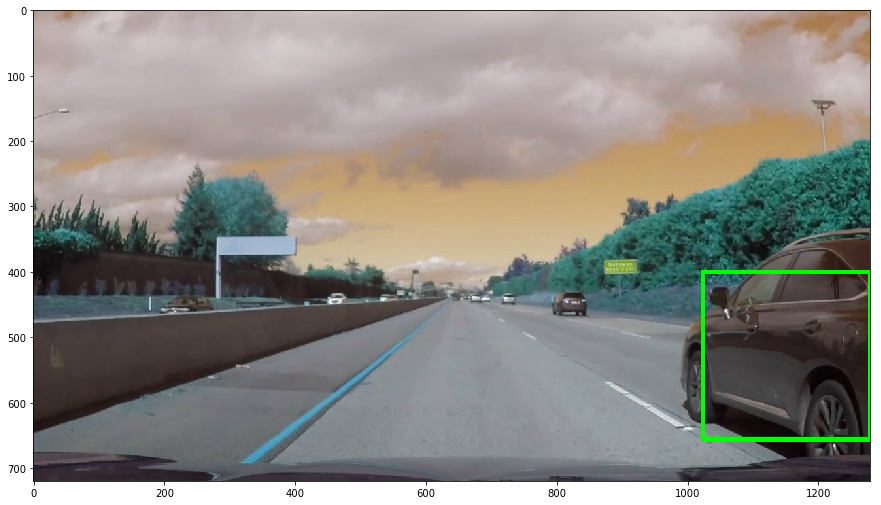

In [424]:
draw_img, heatmap = draw_detections(test_img, ymin, ymax, xmin, xmax, preds, (64,64), scale, step)
plt.figure(figsize=(15,10))
plt.imshow(draw_img)

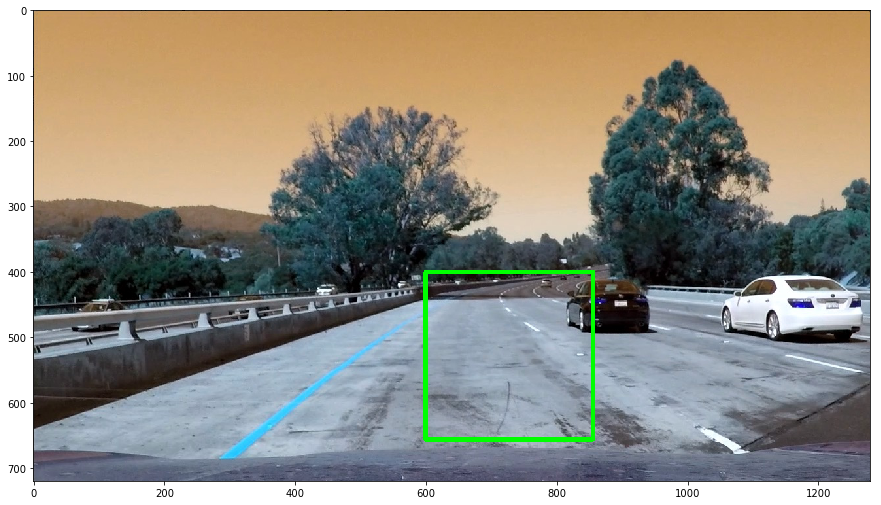

In [420]:
test_img_2 = cv2.imread(test_files[0])
scale = 4
cv2.rectangle(test_img_2,(600,400),(600+scale*64,400+scale*64), (0,255,0), 6)
plt.figure(figsize=(15,10))
plt.imshow(test_img_2)

In [459]:
scale_dict = {0.5:(360,450,0,1280), 1:(360,550,0,1280), 2:(390,600,0,1280)}#,3:(450,720,0,1280), 4:(450,720,0,1280)}
classifier = clf.best_estimator_
im_scaler = scaler
hist_ch = [0,1,2]
ftypes = ['HOG', 'SPAT', 'HIST']
init_size = (64,64)
test_img = cv2.imread(test_files[0])
heatmaps, bboxes_scaled, draw_imgs =  detect_multiscale(test_img, scale_dict, feature_extractor, classifier, im_scaler, threshold=None, return_images=True,
                     feature_types=['HOG', 'SPAT', 'HIST'],
                        init_size=init_size, step=0.5,
                        cell_size=8, hog_color_transform=cv2.COLOR_BGR2GRAY,
                        color_transform=None, spat_size=(32,32),
                        hist_channels=[0,1,2], hist_nbins=32, hist_bins_range=(0,256))


In [532]:
multiscale_heatmap, multiscale_bboxes, draw_img = draw_multiscale(test_img, heatmaps, bboxes_scaled)
#rows, cols= draw_multiscale(test_img, heatmaps, bboxes_scaled)

(1027, 391, 1279, 519)
(820, 390, 959, 508)


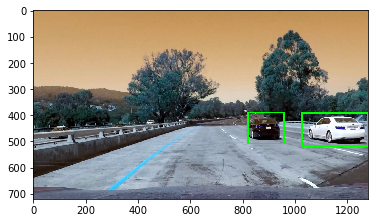

In [533]:
plt.imshow(draw_img)

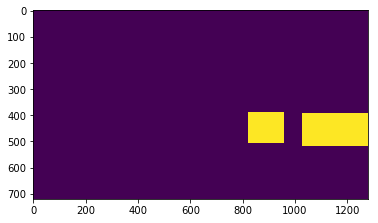

In [534]:
plt.imshow(multiscale_heatmap)

In [522]:
np.array([rows, cols]).T

array([[ 376, 1136],
       [ 376, 1137],
       [ 376, 1138],
       ..., 
       [ 519, 1277],
       [ 519, 1278],
       [ 519, 1279]], dtype=int64)

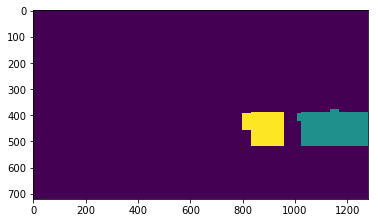

In [497]:
ones_heat = np.zeros_like(heatmaps)
ones_heat[heatmaps>0] = 1
new_ = measurements.label(heatmaps)[0]
plt.imshow(new_)

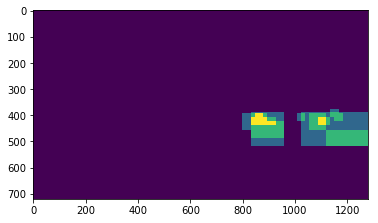

In [442]:
plt.imshow(heatmap)

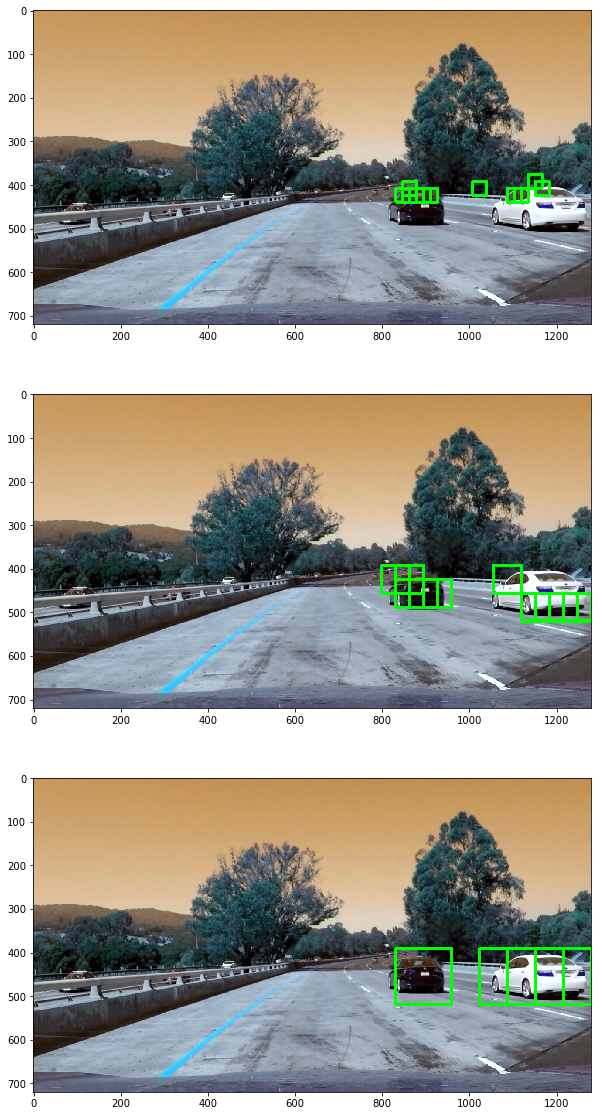

In [445]:
fig = plt.figure(figsize = (10,20))
for i,img in enumerate(imgs):
    a = fig.add_subplot(3,1,i+1)
    plt.imshow(img)
plt.show()

In [386]:
def apply_threshold(heatmap, threshold):
    ans = heatmap.copy()
    ans[ans <= threshold] = 0
    return ans

In [387]:
filtered = apply_threshold(heatmap, 1)

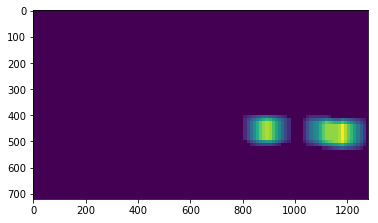

In [388]:
plt.imshow(filtered)

In [389]:
from scipy.ndimage.measurements import label

In [390]:
labels = label(filtered)

In [391]:
labels

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), 2)

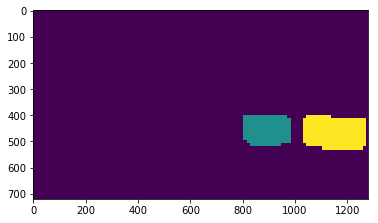

In [392]:
plt.imshow(labels[0])